In [1]:
%matplotlib qt
import mne
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import warnings
from mne_bids import read_raw_bids, make_bids_basename
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

mne.set_log_level('WARNING')
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
def my_var_cut_fn(epochs, plow, phigh, to_plot=True):
    """
    Variance based trial rejection function
    """
    trl_var, trlindx = np.empty((0,1),'float'), np.arange(0,len(epochs))
    for trnum in range(len(epochs)):
        trl_var = np.vstack((trl_var, max(np.var(np.squeeze(epochs[trnum].get_data()), axis=1))))
    lim1 = (trl_var < np.percentile(trl_var, plow, interpolation='midpoint')).flatten()
    lim2 = (trl_var > np.percentile(trl_var, phigh, interpolation='midpoint')).flatten()
    outlr_idx = trlindx[lim1].tolist() + trlindx[lim2].tolist()
    
    if to_plot:
        plt.figure(), plt.scatter(trlindx, trl_var, marker='o', s=50, c='g', label='Good trials'),
        plt.ylabel('Max. variance across channels-->')
        plt.scatter(outlr_idx, trl_var[outlr_idx], marker='o', s=50, c='r', label='Variance based bad trials'),
        plt.xlabel('Trial number-->')
        plt.scatter(badtrls, trl_var[badtrls], marker='o', s=50, c='orange', label='Manually assigned bad trials')
        plt.ylim(min(trl_var)-min(trl_var)*0.01, max(trl_var)+max(trl_var)*0.01), plt.title('Max. variance distribution')
        plt.legend()
        plt.show()
    bad_trials = np.union1d(badtrls, outlr_idx)
    print('Removed trials: %s\n'%bad_trials)
    return bad_trials

In [3]:
#%% Set parameters, directories and filenames
iSub = 7
more_plots = False

par = {'ctrlwin': [-0.5, 0], 'actiwin': [0, 1]}
badtrls, plow, phigh = [], 2.0, 98.0

data_dir = op.expanduser("~/data/pic-name-data-bids/")
sSub, session, task, run = '%02d'%iSub, '01', 'picturenaming', '01'

data_path = op.join(data_dir, 'MEG')
subjects_dir = op.join(data_dir, 'MRI')
subject = 'sub-' + sSub
res_dir = op.join(op.expanduser("~/research/results/pic_name"), subject)

bids_basename = make_bids_basename(subject=sSub, session=session,
                                  task=task, run=run)
bids_fname = bids_basename + '_meg.fif'
bids_path = op.join(data_path, subject, 'ses-'+session, 'meg')

raw_fname = op.join(bids_path, bids_fname)
trans_fname = op.join(bids_path, subject+'-trans.fif')
fwd_fname = op.join(bids_path, subject + '-vol-meg-fwd.fif')

In [4]:
raw = read_raw_bids(bids_fname, data_path, extra_params=dict(allow_maxshield=False,
                                                                        preload=True))

<ipython-input-4-711e95a298be>:2: RuntimeWarning: The unit for channel(s) STI101, STI201, STI301 has changed from V to NA.
  preload=True))
/Users/chholak/anaconda3/lib/python3.7/site-packages/mne_bids/utils.py:635: UserWarning: Did not find any electrodes.tsv file associated with sub-07_ses-01_task-picturenaming_run-01_meg.fif.

The search_str was "/Users/chholak/data/pic-name-data-bids/MEG/sub-07/**/sub-07_ses-01*electrodes.tsv"
  warnings.warn(msg)


In [ ]:
# mne.bem.make_watershed_bem(subject, subjects_dir)

In [5]:
mrifile = op.join(subjects_dir, subject, 'mri/T1.mgz')
surffile = op.join(subjects_dir, subject, 'bem/watershed', subject+'_brain_surface')

In [ ]:
# to_drop = ['STI201', 'STI301', 'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005', 'CHPI006',
#            'CHPI007', 'CHPI008', 'CHPI009']
# raw.drop_channels(to_drop)

In [ ]:
# raw.plot();

In [ ]:
# raw.annotations.save(data_path + subject +'/annot.csv')

In [6]:
events, event_id = mne.events_from_annotations(raw)

In [ ]:
if more_plots:
    mne.viz.plot_events(events, first_samp=0, event_id=event_id,
                       equal_spacing=True, show=True)

In [7]:
picks = mne.pick_types(raw.info, meg=True, eog=True, ecg=True, stim=False, exclude='bads')

In [8]:
#%% Apply filter if required
raw.filter(2, 40, picks=picks, filter_length='auto', n_jobs=1,
          method='fir', iir_params=None, phase='zero', fir_window='hamming',
          fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),
          pad='reflect_limited', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 sec)



<Raw | sub-07_ses-01_task-picturenaming_run-01_meg.fif, 311 x 587000 (587.0 s), ~1.37 GB, data loaded>

In [ ]:
if more_plots:
    raw.plot_psd(fmin=0, fmax=45, proj=False, verbose=True)

In [9]:
epochs = mne.Epochs(raw, events, event_id, -0.5, 1.0,
                   baseline=(-0.5,0), picks=picks, preload=True,
                   reject=None, flat=None, proj=False, decim=1,
                   reject_tmin=None, reject_tmax=None, detrend=None,
                   on_missing='error', reject_by_annotation=True,
                   verbose=True)

111 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 13)
Loading data for 111 events and 1501 original time points ...
0 bad epochs dropped


In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw.copy().filter(1, None))
# eog_epochs.average().plot_joint()
# ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
# ecg_epochs.average().plot_joint()

In [10]:
#% % Find trial variance > index outliers
epochs.pick_types(meg=True)
bad_trials = my_var_cut_fn(epochs, plow, phigh, to_plot=False)
epochs.drop(bad_trials, reason='variance based rejection', verbose=True)
bad_trials = []

Removed trials: [ 19.  31.  70.  82. 105. 107.]

Dropped 6 epochs: 19.0, 31.0, 70.0, 82.0, 105.0, 107.0


In [ ]:
# epochs.average().plot(spatial_colors=True, gfp=True, time_unit='ms')

In [ ]:
# layouts = [mne.find_layout(raw.info, ch_type=ch) for ch in ("mag", "grad")]
# if subject in ['sub-02']:
#     print('Applying EOG projector for', subject)
#     projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_eog, raw.info, layout=layouts);
#     print('Applying ECG projector for', subject)
#     projs_ecg, _ = mne.preprocessing.compute_proj_ecg(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_ecg, raw.info, layout=layouts);
# else:
#     print('Applying EOG projector for', subject)
#     projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_eog, raw.info, layout=layouts);
#     projs_ecg = []

In [ ]:
# evoked = epochs.average()
# evoked.del_proj() # delete previous proj
# #% take first projector for each sensor type
# if subject in ['sub-02']:
#     evoked.add_proj(projs_eog[::3] + projs_ecg[::3])
# else:
#     evoked.add_proj(projs_eog[::3])
# evoked.apply_proj() # apply
# evoked.plot(spatial_colors=True, gfp=True, proj=False, time_unit='ms')

In [ ]:
# epochs.del_proj()
# epochs.add_proj(projs_eog[::3])

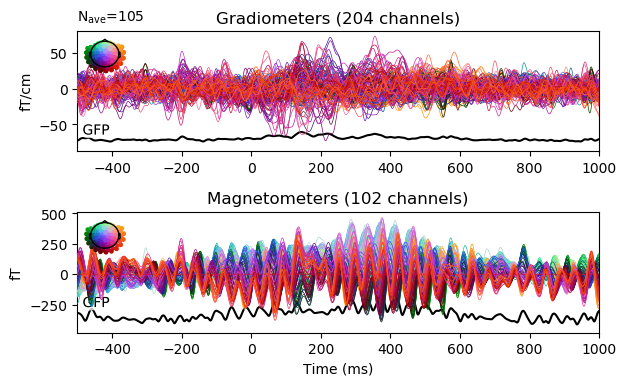

In [11]:
evoked = epochs.average()
evoked.plot(spatial_colors=True, gfp=True, proj=False, time_unit='ms')

In [12]:
plt.savefig(op.join(res_dir, 'evoked_' + subject + '.pdf'))

In [13]:
epochs_fname = op.join(bids_path, bids_fname.replace('_meg.fif', '-epo.fif'))
epochs.save(epochs_fname, overwrite=True)

In [ ]:
# epochs.apply_proj()

In [ ]:
# evoked = epochs.average()

In [15]:
epochs.plot_image(picks='MEG2343', sigma=1);
plt.savefig(op.join(res_dir, 'epochs_MEG2343_' + subject + '.pdf'))

In [16]:
times = [0.15, 0.25] # Highly data dependent
evoked.plot_joint(times=times, picks='mag');
plt.savefig(op.join(res_dir, 'evoked_joint_plot' + subject + '.pdf'))

In [17]:
evoked.plot_topomap(times=np.linspace(0.1, 0.3, 5), ch_type='mag');
plt.savefig(op.join(res_dir, 'evoked_topomap_mag_' + subject + '.pdf'))

In [18]:
epochs.plot_psd_topomap(ch_type='mag', normalize=True, cmap='viridis');
plt.savefig(op.join(res_dir, 'psd_topomap_mag_' + subject + '.pdf'))

epochs.plot_psd_topomap(ch_type='grad', normalize=True, cmap='viridis');
plt.savefig(op.join(res_dir, 'psd_topomap_grad_' + subject + '.pdf'))

In [ ]:
plt.close('all')

In [19]:
freqs = np.logspace(*np.log10([2, 30]), num=20)
n_cycles = freqs / 2.
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                       return_itc=True, decim=3, n_jobs=1)

power.crop(-0.1, 0.8)
itc.crop(-0.1, 0.8)
baseline_mode = 'logratio'
baseline = (None, 0)

In [ ]:
# for inx, name in enumerate(epochs.ch_names):
#     if name == 'MEG2343':
#         print("MEG 2343 is channel #", inx)

In [20]:
power.plot([267], baseline=baseline, mode=baseline_mode);
plt.savefig(op.join(res_dir, 'power_MEG2343_' + subject + '.pdf'))

In [21]:
fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=4, fmax=7,
                  baseline=baseline, mode=baseline_mode, axes=axis[0],
                  title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=8, fmax=12,
                  baseline=baseline, mode=baseline_mode, axes=axis[1],
                  title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=15, fmax=30,
                  baseline=baseline, mode=baseline_mode, axes=axis[2],
                  title='Beta', show=False, contours=1)
mne.viz.tight_layout()
plt.show()

plt.savefig(op.join(res_dir, 'power_topomap_t=0-0p6_' + subject + '.pdf'))

In [22]:
itc.plot([267], baseline=baseline, mode=baseline_mode);
plt.savefig(op.join(res_dir, 'itc_MEG2343_' + subject + '.pdf'))

In [23]:
itc.plot_topomap(ch_type='mag', tmin=0.1, tmax=0.3, fmin=3.5, fmax=7.,
                baseline=baseline, mode='mean', size=6)
mne.viz.tight_layout()
plt.savefig(op.join(res_dir, 'itc_topomap_' + subject + '.pdf'))

In [24]:
plt.close('all')

In [25]:
src_vol = mne.setup_volume_source_space(subject=subject, pos=5.0,
            mri=mrifile, bem=None, surface=surffile, mindist=2.5,
            exclude=10, subjects_dir=subjects_dir, volume_label=None,
            add_interpolator=None, verbose=True)

Boundary surface file : /Users/chholak/data/pic-name-data-bids/MRI/sub-07/bem/watershed/sub-07_brain_surface
grid                  : 5.0 mm
mindist               : 2.5 mm
Exclude               : 10.0 mm
MRI volume            : /Users/chholak/data/pic-name-data-bids/MRI/sub-07/mri/T1.mgz

Loaded bounding surface from /Users/chholak/data/pic-name-data-bids/MRI/sub-07/bem/watershed/sub-07_brain_surface (10242 nodes)
Surface CM = (  -0.5  -21.1    6.2) mm
Surface fits inside a sphere with radius   96.3 mm
Surface extent:
    x =  -72.5 ...   73.6 mm
    y = -110.7 ...   72.3 mm
    z =  -71.0 ...   86.4 mm
Grid extent:
    x =  -75.0 ...   75.0 mm
    y = -115.0 ...   75.0 mm
    z =  -75.0 ...   90.0 mm
41106 sources before omitting any.
27693 sources after omitting infeasible sources not within 10.0 - 96.3 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    2.5 mm away (will take a few...)
    Skipping interior check for 2815 sources

In [26]:
info = mne.io.read_info(raw_fname)
# mne.viz.plot_alignment(info, trans_fname, subject=subject,
#                       src=src_vol, subjects_dir=subjects_dir, dig=True,
#                       surfaces=['head', 'white'], coord_frame='meg', meg=False)

In [27]:
model = mne.make_bem_model(subject=subject, ico=4, conductivity=(0.33,),
            subjects_dir=subjects_dir, verbose=True)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.53 -21.10   6.21 mm
Surfaces passed the basic topology checks.
Complete.



In [28]:
bem_fname = op.join(bids_path, subject + '-grid-bem.fif')
mne.bem.write_bem_solution(bem_fname, bem)

In [29]:
fwd = mne.make_forward_solution(evoked.info, trans=trans_fname, src=src_vol,
        bem=bem, meg=True, eeg=False, mindist=2.5, n_jobs=1)
print("Leadfield size : %d sensors x %d dipoles" % fwd['sol']['data'].shape)

Leadfield size : 306 sensors x 42657 dipoles


In [30]:
# fwd_fname = op.join(bids_path, subject + '-vol-meg-fwd.fif')
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

In [31]:
# Compute covariance
noise_cov = mne.compute_covariance(epochs,
                tmin=par['ctrlwin'][0], tmax=par['ctrlwin'][1],
                method='empirical', rank='info', verbose=True)

data_cov = mne.compute_covariance(epochs,
                tmin=par['actiwin'][0], tmax=par['actiwin'][1],
                method='empirical', rank='info', verbose=True)

Computing rank from data with rank='info'
    MEG: rank 293 after 13 projectors applied to 306 channels
    Created an SSP operator (subspace dimension = 13)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 293
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 52605
[done]
Computing rank from data with rank='info'
    MEG: rank 293 after 13 projectors applied to 306 channels
    Created an SSP operator (subspace dimension = 13)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 293
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 105105
[done]


In [ ]:
# mne.viz.plot_cov(noise_cov, epochs.info)

In [32]:
evoked.plot_white(noise_cov);
plt.savefig(op.join(res_dir, 'evoked_plot_white_' + subject + '.pdf'))

In [33]:
# Compute inverse
inverse_operator = mne.minimum_norm.make_inverse_operator(info, 
    fwd, noise_cov, rank=None, loose=1, depth=0.199, verbose=True)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 5949/14219 = 10.000909
    scale = 5.3938e-07 exp = 0.199
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 13)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 306 dim * 18  max singular value)
    Estimated rank (mag + grad): 293
    MEG: rank 293 computed from 306 data channels with 13 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 15.6787
    scaling factor to adjust the trace = 1.5371e+28


In [34]:
# Compute SNR
snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)
nt_snr = np.argmax(snr)
SNR = snr[nt_snr]
print('\nMax SNR at %0.3f s : %0.3f' % (evoked.times[nt_snr], SNR))

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 105
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 13)
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
Picked 306 channels from the data
Effective nchan = 306 - 13 = 293

Max SNR at 0.788 s : 150.609


<ipython-input-34-0eec8210817c>:2: RuntimeWarning: SNR estimation did not converge
  snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)


In [35]:
# Compute filter and output
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
            noise_cov=noise_cov, pick_ori='max-power', rank=None,
            weight_norm='nai', reduce_rank=True, verbose=True)

stc = mne.beamformer.apply_lcmv(evoked, filters, max_ori_out='signed', verbose=True)

Computing rank from covariance with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 306 dim * 18  max singular value)
    Estimated rank (mag + grad): 292
    MEG: rank 292 computed from 306 data channels with 13 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 306 dim * 18  max singular value)
    Estimated rank (mag + grad): 293
    MEG: rank 293 computed from 306 data channels with 13 projectors


ValueError: meg data rank (292) did not match the noise rank (293)

In [ ]:
stc_fname = op.join(res_dir, 'lcmv_' + subject)
stc.save(stc_fname)

In [ ]:
stc = np.abs(stc)

In [ ]:
_, t_peak = stc.get_peak()
print('Source peaked at = %0.3f' % t_peak)
nt_src_peak = int(t_peak//stc.tstep - stc.times[0]//stc.tstep)

In [ ]:
img = stc.as_volume(fwd['src'], dest='mri', mri_resolution=False, format='nifti1')

In [ ]:
plot_stat_map(index_img(img, nt_src_peak), mrifile, threshold=stc.data.max()*0.70)
plt.savefig(op.join(res_dir,
        'stat_map_' + 'time=%0.3fs_'%(stc.times[nt_src_peak]) + subject + '.pdf'))

In [ ]:
plot_stat_map(index_img(img, nt_snr), mrifile, threshold=stc.data.max()*0.30)
plt.savefig(op.join(res_dir,
        'stat_map_' + 'time=%0.3fs_'%(stc.times[nt_snr]) + subject + '.pdf'))

In [ ]:
plt.close('all')